In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import os
os.chdir("C:/Users/joseh/OneDrive - Universidad de los Andes\MIAD\Proyecto de grado/ElectroDunas")
import Funciones_Procesamiento as fp
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, Birch, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Ruta de la carpeta que contiene los archivos CSV
carpeta = './Datos Electro Dunas'

# Diccionario para almacenar los DataFrames con nombres originales como claves
dataframes_dict = {}

# Recorre todos los archivos en la carpeta
for archivo in os.listdir(carpeta):
    # Verifica que el archivo sea un archivo CSV
    if archivo.endswith('.csv'):
        # Construye la ruta completa del archivo
        ruta_archivo = os.path.join(carpeta, archivo)
        
        # Lee el archivo CSV y lo agrega al diccionario
        df = pd.read_csv(ruta_archivo)
        dataframes_dict[archivo] = df

Este código verifica si todos los DataFrames en el diccionario tienen las mismas columnas. Esto para asegurarse de que los datos de diferentes archivos son consistentes y se pueden combinar o comparar de manera segura:

In [2]:
# Verifica que todas las bases de datos tengan el mismo número de columnas
columnas_primer_df = set(dataframes_dict[list(dataframes_dict.keys())[0]].columns)
todas_las_columnas_coinciden = all(
    set(df.columns) == columnas_primer_df for df in dataframes_dict.values()
)

# Imprime el resultado
if todas_las_columnas_coinciden:
    print("Todas las DataFrames tienen las mismas columnas.")
else:
    print("Las columnas de las DataFrames no coinciden.")

Todas las DataFrames tienen las mismas columnas.


Este código verifica si todas las fechas en todos los DataFrames tienen el formato correcto. Si no es así, intenta convertir las fechas al formato correcto y maneja los errores reemplazando las fechas no válidas con valores nulos:

In [3]:
# Verifica que todas las observaciones en la columna de fechas tengan el mismo formato
formato_fecha = "%Y-%m-%d %H:%M:%S"
todas_las_fechas_coinciden = all(
    all(pd.to_datetime(df['Fecha'], format=formato_fecha, errors='coerce').notnull())
    for df in dataframes_dict.values()
)

# Imprime el resultado
if todas_las_fechas_coinciden:
    print("Todas las observaciones en la columna de fechas tienen el mismo formato.")
else:
    print("NO todas las observaciones en la columna de fechas tienen el mismo formato. Se inicia proceso de transformación al formato ideal.")
    # Itera sobre cada DataFrame en el diccionario
    for nombre, df in dataframes_dict.items():
        try:
            # Intenta convertir las fechas al formato especificado
            df['Fecha'] = pd.to_datetime(df['Fecha'], format=formato_fecha)
        except ValueError as e:
            print(f"Error al convertir las fechas en el DataFrame {nombre}: {e}")
            # Aquí puedes manejar el error como prefieras
            # Por ejemplo, podrías reemplazar las fechas no válidas con NaT
            df['Fecha'] = pd.to_datetime(df['Fecha'], format=formato_fecha, errors='coerce')
        
    # Actualiza el DataFrame en el diccionario
    dataframes_dict[nombre] = df

Todas las observaciones en la columna de fechas tienen el mismo formato.


En este código, realizamos una verificación para detectar la presencia de datos faltantes. Si se encuentran tales datos, aplicamos un método de imputación basado en los K-Vecinos Más Cercanos (KNN), específicamente utilizando los tres vecinos más cercanos para tratar estos datos faltantes. La fortaleza de este método radica en su capacidad para preservar las relaciones entre las variables, manejar outliers y adaptarse a diferentes distribuciones de datos, por lo que este enfoque puede ser particularmente efectivo para imputar datos faltantes en variables como la energía activa, la energía reactiva o el voltaje.

In [4]:
# Crea el imputador KNN
imputador = KNNImputer(n_neighbors=3)

# Inicializa un contador para los datos faltantes
contador_datos_faltantes = 0

# Itera sobre cada DataFrame en el diccionario
for nombre, df in dataframes_dict.items():
    # Cuenta los datos faltantes en el DataFrame actual
    datos_faltantes = df.isnull().sum().sum()
    
    # Agrega al contador
    contador_datos_faltantes += datos_faltantes
    
    # Separa la columna 'Fecha'
    fechas = df['Fecha']
    df = df.drop(columns='Fecha')
    
    # Imputa los datos faltantes con el imputador KNN
    df_imputado = imputador.fit_transform(df)
    
    # Convierte el resultado (que es un array de numpy) de nuevo a un DataFrame
    df = pd.DataFrame(df_imputado, columns=df.columns)
    
    # Vuelve a añadir la columna 'Fecha'
    df['Fecha'] = fechas
    
    # Actualiza el DataFrame en el diccionario
    dataframes_dict[nombre] = df

# Imprime el número total de datos faltantes que se tuvieron que cambiar
print(f"Se tuvieron que cambiar {contador_datos_faltantes} datos faltantes.")

Se tuvieron que cambiar 0 datos faltantes.


Se agrega la columna cliente a cada dataframe:

In [5]:
# Itera sobre cada DataFrame en el diccionario
for nombre, df in dataframes_dict.items():
    # Extrae el número de cliente del nombre del archivo
    numero_cliente = int(nombre.split('CLIENTE')[1].split('.')[0])
    
    # Añade la columna 'Cliente' usando el número de cliente
    df['Cliente'] = f"Cliente {numero_cliente}"
    
    # Actualiza el DataFrame en el diccionario
    dataframes_dict[nombre] = df

En los siguientes códigos cargamos, modificamos y agregamos a cada dataframe el sector económico de cada cliente:

In [6]:
# Ruta del archivo CSV con las clasificaciones de sector económico
ruta_archivo_sector = './Datos Electro Dunas/sector_economico_clientes.xlsx'

df_sector = pd.read_excel(ruta_archivo_sector)

# Cambia los nombres de las columnas
nuevos_nombres = ['Cliente', 'Sector']  # Lista con los nuevos nombres
df_sector.columns = nuevos_nombres

df_sector['Cliente'] = df_sector['Cliente'].apply(lambda x: "Cliente " + str(x.split(' ')[1]))

df_sector.head()

,Cliente,Sector
0,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,Cliente 2,Elaboración de cacao y chocolate y de producto...
2,Cliente 3,Elaboración de cacao y chocolate y de producto...
3,Cliente 4,Elaboración de cacao y chocolate y de producto...
4,Cliente 5,Elaboración de cacao y chocolate y de producto...


In [7]:
# Itera sobre cada DataFrame en el diccionario para agregar la columna sector
for nombre, df in dataframes_dict.items():
    # Combina el DataFrame con df_sector basándose en la columna 'Cliente'
    df_combinado = pd.merge(df, df_sector, on='Cliente', how='left')
    
    # Actualiza el DataFrame en el diccionario
    dataframes_dict[nombre] = df_combinado

In [8]:
df=dataframes_dict["DATOSCLIENTE1.csv"]
df.head()

,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Fecha,Cliente,Sector
0,0.357841,0.282788,455.139171,510.561002,2021-01-01 00:00:00,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,0.372264,0.431377,469.978787,469.917178,2021-01-01 01:00:00,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,1.044687,0.338626,468.721120,546.949147,2021-01-01 02:00:00,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,0.566425,0.495791,452.329255,444.122989,2021-01-01 03:00:00,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,1.080556,0.472018,513.477596,535.463719,2021-01-01 04:00:00,Cliente 1,Elaboración de cacao y chocolate y de producto...


Dado que nuestro objetivo es detectar anomalías en la energía activa, reactiva y el voltaje, podemos representar estos elementos en un triángulo de potencias. En este triángulo, la potencia aparente forma la hipotenusa, mientras que las potencias activa y reactiva corresponden a los catetos adyacente y opuesto, respectivamente.

El Factor de Potencia (FP), que es la relación entre la potencia activa y la potencia aparente, nos ayuda a entender qué tan eficientemente se está utilizando la energía. Un FP cercano a 1 indica que la mayor parte de la energía se está convirtiendo en trabajo útil. Sin embargo, un FP significativamente menor que 1 puede ser una señal de anomalía, ya que implica que una gran cantidad de energía se está almacenando y liberada sin realizar trabajo útil.

Por lo tanto, monitorear el FP puede ser una estrategia efectiva para detectar anomalías en nuestro experimento. En el siguiente código, calcularemos y añadiremos a los dataframes las columnas Potencia Aparente y Factor Potencia, el cual lo multiplicaremos por 100 para obtener el porcentaje:

In [9]:
# Añadimos la columna Potencia aparente y el factor potencia a cada DataFrame en el diccionario
for df in dataframes_dict.values():
    df['Potencia_Aparente'] = np.sqrt(df['Active_energy']**2 + df['Reactive_energy']**2)
    df['Factor_Potencia_%'] = (df['Active_energy'] / (df['Potencia_Aparente'] + 1e-10)) * 100

En el contexto de nuestro experimento, estamos analizando las variables Voltaje_FA y Voltaje_FC, que representan medidas de voltaje en un sistema eléctrico trifásico. Un sistema trifásico consta de tres corrientes alternas (AC) que se desplazan en el tiempo, comúnmente denominadas Fase A, Fase B y Fase C. Estas mediciones de voltaje son cruciales para comprender el comportamiento del sistema eléctrico y asegurar que los dispositivos conectados a cada fase funcionen correctamente.

Un aspecto importante a considerar es el desequilibrio de voltaje, que es la discrepancia en la tensión entre las fases de un sistema trifásico. Este desequilibrio puede afectar negativamente el rendimiento y acortar la vida útil de los motores trifásicos. Además, puede causar un rendimiento deficiente o fallos prematuros en los motores trifásicos y otras cargas trifásicas.

En nuestros datos, contamos solamente con las mediciones de voltaje para las Fases A y C (Voltaje_FA y Voltaje_FC). Si estos voltajes presentan diferencias significativas, esto podría indicar un desequilibrio en el sistema. Además, si notamos que estos voltajes varían de manera inconsistente con el tiempo, esto también podría ser una señal de un problema potencial en el sistema.

Dado lo anterior, vamos a agregar una columna con el desequilibrio del voltaje y otra en su equivalente como un porcentaje:

In [10]:
# Añadimos la columna Desequilibrio voltaje a cada DataFrame en el diccionario
for df in dataframes_dict.values():
    df['Desequilibrio_Voltaje'] = abs(df['Voltaje_FA'] - df['Voltaje_FC'])
    df['Desequilibrio_Voltaje_%'] = (df['Desequilibrio_Voltaje'] / (df[['Voltaje_FA', 'Voltaje_FC']].min(axis=1) + 1e-10)) * 100

Le damos un vistazo a algunos dataframes como ejemplo:

In [11]:
df_c1=dataframes_dict["DATOSCLIENTE1.csv"]
df_c1.head()

,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Fecha,Cliente,Sector,Potencia_Aparente,Factor_Potencia_%,Desequilibrio_Voltaje,Desequilibrio_Voltaje_%
0,0.357841,0.282788,455.139171,510.561002,2021-01-01 00:00:00,Cliente 1,Elaboración de cacao y chocolate y de producto...,0.456091,78.458160,55.421831,12.176898
1,0.372264,0.431377,469.978787,469.917178,2021-01-01 01:00:00,Cliente 1,Elaboración de cacao y chocolate y de producto...,0.569796,65.332940,0.061610,0.013111
2,1.044687,0.338626,468.721120,546.949147,2021-01-01 02:00:00,Cliente 1,Elaboración de cacao y chocolate y de producto...,1.098198,95.127407,78.228027,16.689674
3,0.566425,0.495791,452.329255,444.122989,2021-01-01 03:00:00,Cliente 1,Elaboración de cacao y chocolate y de producto...,0.752759,75.246475,8.206266,1.847746
4,1.080556,0.472018,513.477596,535.463719,2021-01-01 04:00:00,Cliente 1,Elaboración de cacao y chocolate y de producto...,1.179154,91.638298,21.986123,4.281808


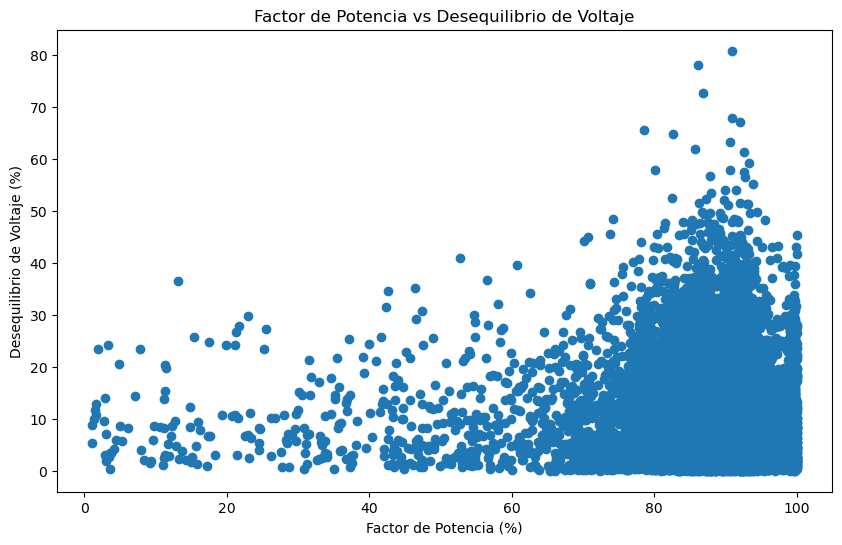

In [12]:
# Gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df_c1['Factor_Potencia_%'], df_c1['Desequilibrio_Voltaje_%'])
plt.title('Factor de Potencia vs Desequilibrio de Voltaje')
plt.xlabel('Factor de Potencia (%)')
plt.ylabel('Desequilibrio de Voltaje (%)')
plt.show()

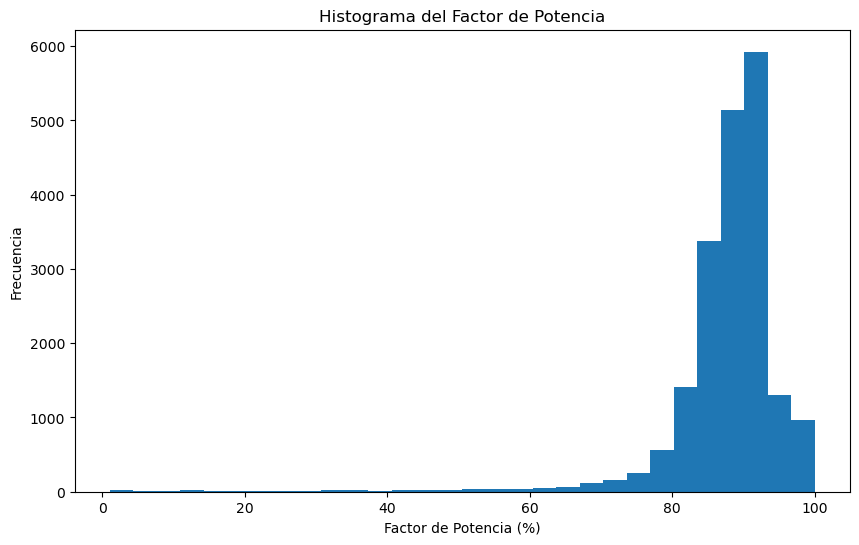

In [13]:
# Histograma del Factor de Potencia
plt.figure(figsize=(10, 6))
plt.hist(df_c1['Factor_Potencia_%'], bins=30)
plt.title('Histograma del Factor de Potencia')
plt.xlabel('Factor de Potencia (%)')
plt.ylabel('Frecuencia')
plt.show()

En nuestros experimentos, buscamos anomalías en la energía activa, reactiva y el voltaje utilizando métodos de clustering y técnicas de detección de anomalías como DBSCAN, LOF y el método de aislamiento de bosques. Estos algoritmos están diseñados específicamente para identificar puntos de datos que son inusuales o diferentes de la mayoría. Un bajo factor de potencia y un alto desequilibrio de voltaje pueden indicar problemas. Estos pueden llevar a un mayor consumo de corriente, pérdida de eficiencia, reducción de la capacidad del sistema, penalizaciones económicas, desgaste prematuro de equipos y problemas de calidad de energía. Por lo tanto, es crucial monitorear estos aspectos para garantizar la eficiencia y longevidad de los equipos eléctricos, así como la calidad de la energía en el sistema:

In [14]:
# Agregar columna de fecha a cada DataFrame
for nombre, df in dataframes_dict.items():
    dataframes_dict[nombre] = fp.agregar_col_fecha(df)

In [15]:
df_c1=dataframes_dict["DATOSCLIENTE10.csv"]
df_c1.head()

,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Fecha,Cliente,Sector,Potencia_Aparente,Factor_Potencia_%,Desequilibrio_Voltaje,Desequilibrio_Voltaje_%,Mes,Año,Dia,Hora,Nombre_dia,Fin_de_semana,Horario_laboral,Dia_semana
0,2.873046,0.508548,1557.057893,1312.106981,01/01/2021,Cliente 10,Cultivo de Árboles Frutales y Nueces,2.917707,98.469312,244.950912,18.668517,1,2021,1,0,Friday,0,0,4
1,2.037791,0.532105,1456.095693,1329.850730,01/01/2021,Cliente 10,Cultivo de Árboles Frutales y Nueces,2.106117,96.755835,126.244963,9.493168,1,2021,1,1,Friday,0,0,4
2,2.358945,0.797515,1226.481132,1301.578937,01/01/2021,Cliente 10,Cultivo de Árboles Frutales y Nueces,2.490110,94.732534,75.097805,6.123030,1,2021,1,2,Friday,0,0,4
3,1.347161,0.472839,1138.403031,1379.538878,01/01/2021,Cliente 10,Cultivo de Árboles Frutales y Nueces,1.427733,94.356690,241.135848,21.181940,1,2021,1,3,Friday,0,0,4
4,2.486699,0.488362,1062.467048,1594.077359,01/01/2021,Cliente 10,Cultivo de Árboles Frutales y Nueces,2.534200,98.125604,531.610311,50.035463,1,2021,1,4,Friday,0,0,4


In [16]:
# Definición de columnas para el proceso de clustering
mod_cols = ['Cliente', 'Factor_Potencia_%', 'Desequilibrio_Voltaje_%', 'Hora', 'Dia_semana']
df_copies = [df.copy() for df in dataframes_dict.values()]
for i, df in enumerate(df_copies):
    df_copies[i] = df_copies[i][mod_cols]

In [18]:
# Crear dataframe para las métricas de los modelos
metricas = pd.DataFrame(columns=['Cliente', 'Modelo', 'Silhouette', 'Davies Bouldin', 'Calinski Harabasz'])

# Probar diferentes modelos para clustering con k = 2
k = 2
scaler = StandardScaler()
kmeans = KMeans(n_clusters=k)
birch = Birch(n_clusters=k)
spectral = SpectralClustering(n_clusters=k)
dbscan = DBSCAN(eps=0.3)  # Puedes ajustar el parámetro eps según tus datos

modelos = [kmeans, birch, spectral, dbscan]
nombres = ['KMeans', 'Birch', 'Spectral', 'DBSCAN']

for i, modelo in enumerate(modelos):
    for j, df in enumerate(df_copies):
        cliente = df['Cliente'].iloc[0]
        # Asumiendo que 'Fecha' es la única columna no numérica en tu DataFrame
        columnas_numericas = df.drop('Cliente', axis=1).columns
        # Escalar los datos
        X = scaler.fit_transform(df[columnas_numericas])
        # Entrenar el modelo
        modelo.fit(X)
        # Agregar columna de cluster al dataframe con el modelo
        df_copies[j]['Cluster_' + nombres[i]] = modelo.labels_
        # Calcular las métricas
        sil = silhouette_score(X, modelo.labels_)
        db = davies_bouldin_score(X, modelo.labels_)
        ch = calinski_harabasz_score(X, modelo.labels_)
        # Agregar las métricas al dataframe
        metricas.loc[len(metricas)] = [cliente, nombres[i], sil, db, ch]

# Determinar el mejor modelo para cada métrica
mejor_silhouette = metricas.loc[metricas['Silhouette'].idxmax()]['Modelo']
mejor_davies_bouldin = metricas.loc[metricas['Davies Bouldin'].idxmin()]['Modelo']
mejor_calinski_harabasz = metricas.loc[metricas['Calinski Harabasz'].idxmax()]['Modelo']

# Agregar una columna a 'metricas' para cada métrica que indique si ese modelo es el mejor
metricas['Mejor_Silhouette'] = metricas['Modelo'] == mejor_silhouette
metricas['Mejor_Davies_Bouldin'] = metricas['Modelo'] == mejor_davies_bouldin
metricas['Mejor_Calinski_Harabasz'] = metricas['Modelo'] == mejor_calinski_harabasz

metricas


,Cliente,Modelo,Silhouette,Davies Bouldin,Calinski Harabasz,Mejor_Silhouette,Mejor_Davies_Bouldin,Mejor_Calinski_Harabasz
0,Cliente 1,KMeans,0.214098,1.832945,4561.691386,False,False,False
1,Cliente 10,KMeans,0.263151,1.581635,4557.701627,False,False,False
2,Cliente 11,KMeans,0.228127,1.755316,3268.595365,False,False,False
3,Cliente 12,KMeans,0.305765,1.377683,2890.917285,False,False,False
4,Cliente 13,KMeans,0.379297,1.190577,4392.834355,False,False,False
...,...,...,...,...,...,...,...,...
115,Cliente 5,DBSCAN,-0.259201,1.428707,293.559084,False,False,False
116,Cliente 6,DBSCAN,-0.183766,2.115678,708.672297,False,False,False
117,Cliente 7,DBSCAN,0.172592,1.737824,949.570429,False,False,False
118,Cliente 8,DBSCAN,0.006996,2.861693,419.254879,False,False,False
